# Описание проекта

## Задача

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

Задача — провести анализ и подготовить план действий по удержанию клиентов. А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

Выводы и рекомендации включают следующие пункты: 1) выделить целевые группы клиентов; 2) предложить меры по снижению оттока; 3) определить другие особенности взаимодействия с клиентами.

## Описание данных

Набор данных включает следующие поля:

**Данные клиента за предыдущий до проверки факта оттока месяц:**
* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

* 'Churn' — факт оттока в текущем месяце.

## Шаг 1. Загрузка и предобработка данных

Первым делом импортируем нужные библиотеки и читаем файл.

In [1]:
# импорт нужных библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# чтение файла
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Будет удобнее привести названия столбцов к нижнему регистру.

In [2]:
# приведение названий столбцов к нижнему регистру
gym.columns = gym.columns.str.lower()
# проверка
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Теперь посмотрим на типы данных и размер таблицы.

In [3]:
# общая информация по таблице
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Пропусков нет. Срок до окончания текущего действующего абонемента (в месяцах) нужно привести к целочисленному типу, т.к. он выражен месяцами, что тоже целые числа. Можно округлить среднюю частоту посещений и суммарную выручку от услуг фитнес-центра.

In [4]:
# округление и замена типа
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype(int)

gym['avg_additional_charges_total'] = gym['avg_additional_charges_total'].round(2)
gym['avg_class_frequency_total'] = gym['avg_class_frequency_total'].round(2)
gym['avg_class_frequency_current_month'] = gym['avg_class_frequency_current_month'].round(2)

gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0


Осталось только проверить наличие дубликатов.

In [5]:
# проверка дубликатов
gym.duplicated().sum()

0

Теперь мы уверены, что данные в порядке. Идем дальше.

## Шаг 2. Исследовательский анализ данных (EDA)

Посмотрим на статистику по таблице, изучим средние значения и стандартные отклонения.

In [6]:
# статистика по таблице
gym.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.86,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


У нас есть некоторая информация о клиентах:
* Мужчин и женщин примерно равное количество;
* Средний возраст клиентов - 29 лет;
* 85% клиентов живут или работают в том же районе, где находится фитнес-центр;
* Сотрудниками компании-партнера клуба являются 49% клиентов;
* 31% клиентов использовали промо-код от знакомого, когда пришли впервые;
* 90% клиентов оставили свой номер телефона;
* Занятия в группах посещают 41% клиентов;
* В среднем с момента первого посещения прошло 3,7 месяца;
* Текущий действующий абонемент оформлен в среднем 4,6 месяца назад, но не менее половины клиентов оформляют абонемент на месяц;
* Срок до окончания текущего действующего абонемента - 4,3 месяца в среднем;
* Средняя частота посещений в неделю за все время с начала действия абонемента - 1,9 раз;
* Средняя частота посещений в неделю за предыдущий месяц - 1,8 раз;
* Выручка от других услуг фитнес-центра составляет в среднем 147 условных единиц.

Доля оттока составляет 27% клиентов.

По средним значениям сравним тех, кто ушел в отток и остался. Для этого сгруппируем данные.

In [7]:
# средние значения для тех, кто ушел и остался
gym.groupby('churn').agg('mean').round(2).T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Построим теперь столбчатые гистограммы и распределения признаков для тех, кто ушел и тех, кто остался.

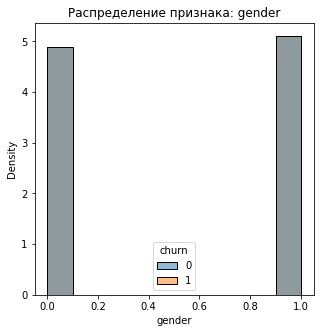

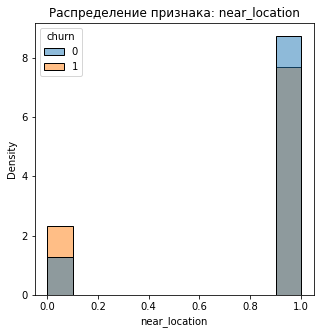

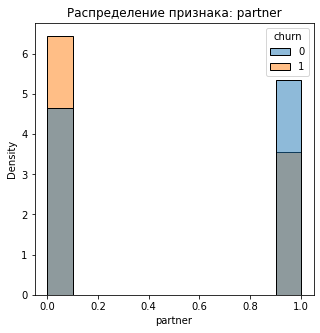

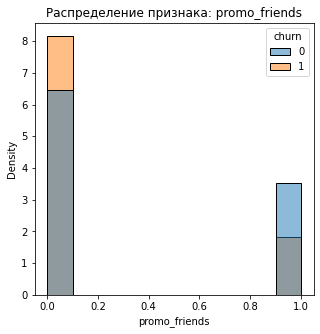

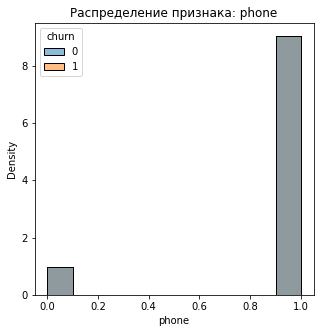

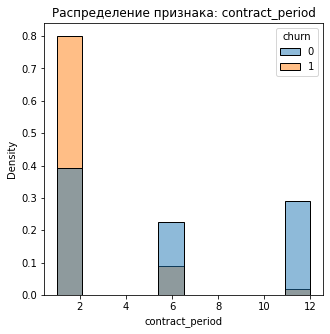

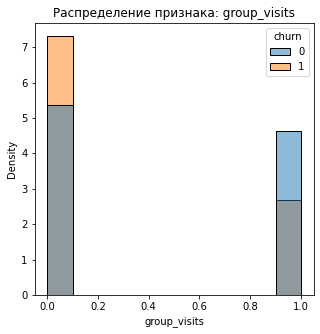

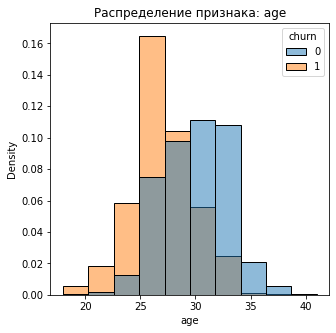

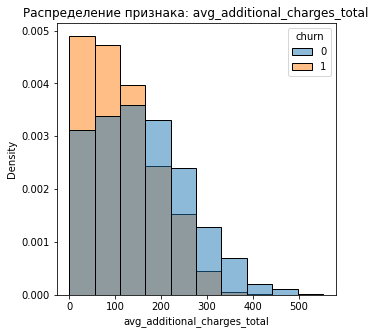

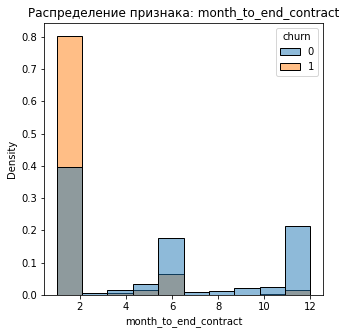

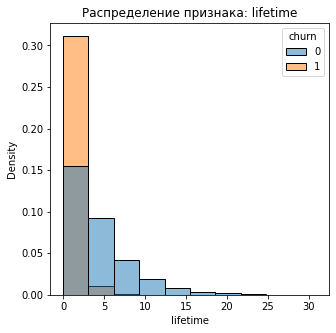

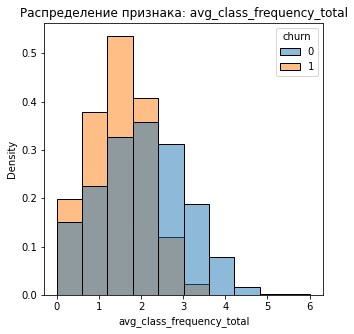

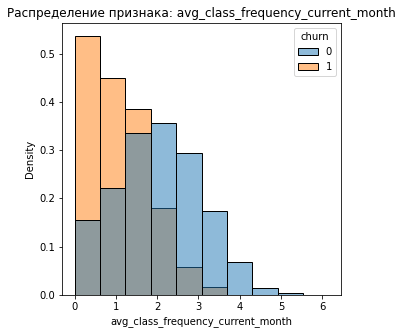

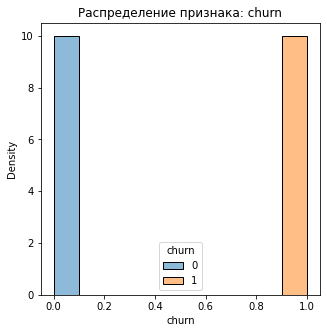

In [13]:
# распределение признаков для оставшихся и ушедших
for column in gym.columns:
    plt.figure(figsize = (5,5))
    plt.title("Распределение признака: " + column)
    sns.histplot(x = gym[column], bins = 10, hue = gym['churn'], stat = "density", common_norm = False)
    plt.show()

Графики и статистика говорят о том, что распределение по полу и наличию контактного телефона одинаковы. Но различий много. Клиенты, которые ушли в отток:
* В среднем чуть моложе на три года;
* Реже живут или работают в том же районе, где находится фитнес-центр;
* Реже являются сотрудниками компании-партнера клуба;
* В два раза реже записываются по акции «приведи друга»;
* Реже посещают групповые занятия;
* Берут абонемент, который в среднем в три раза короче;
* Чаще являются владельцами абонементов, которые скоро закончатся;
* Ушли намного раньше с момента первого обращения;
* В среднем посетили меньше занятий в неделю за все время и предыдущий месяц;
* Меньше принесли денег фитнес-центру за прочие услуги.

Предположим, что главными факторами оттока являются минимальный период абонемента, отказ от посещений групповых занятий, редкое посещение фитнес-центра в неделю, работа в компании, не являющейся партнером, и отсутствие промокода от друга.

Посмотрим на корреляцию признаков друг с другом.

In [ ]:
# матрица корреляций
corr_matrix = gym.corr()

plt.figure(figsize = (10,7))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f')
plt.title('Матрица корреляций признаков', fontsize = 12)
plt.show()

Есть две вещи, о которых говорит тепловая карта.

1) Есть два признака, которые не коррелируют ни с чем. Это пол клиента и наличие телефонного номера.

2) Сильно коррелируют между собой две пары признаков:
* средняя частота посещений в неделю за все время с начала действия абонемента - средняя частота посещений в неделю за предыдущий месяц;
* длительность текущего действующего абонемента (месяц, 6 месяцев, год) - срок до окончания текущего действующего абонемента (в месяцах).

Эти признаки обозначают почти одно и то же, так что в каждой паре следует избавиться от одного, потому что это мешает обучению модели.

In [ ]:
# удаление столбцов с сильной корреляцией
gym_clear = gym.drop(['avg_class_frequency_total', 'month_to_end_contract'], axis = 1)

Исследовательский анализ данных завершен. Можно переходить к обучению моделей.

## Шаг 3. Модель прогнозирования оттока клиентов

Необходимо построить модель бинарной классификации клиентов, где целевой признак - факт оттока клиента в следующем месяце. Сначала разобьем данные на обучающую и валидационную выборку.

In [ ]:
# разбивка данных на обучающую и валидационную выборки
# признаки
X = gym_clear.drop('churn', axis = 1)
# целевая переменная
y = gym_clear['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Признаки имеют разный вес, и лучше привести их к единому масштабу, чтобы сравнивать. Для этого проводим стандартизацию данных.

In [ ]:
# стандартизация данных
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Теперь можно обучать модель на train-выборке. Попробуем два способа: логистическая регрессия и случайный лес.

**Логистическая регрессия:**

In [ ]:
# алгоритм и обучение модели логистической регрессии
lr_model = LogisticRegression(random_state = 0)
lr_model.fit(X_train_st, y_train)
# прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

**Случайный лес:**

In [ ]:
# алгоритм и обучение модели случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
# прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

Модели обучены. Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

Accuracy = доля правильных ответов. Precision = точность модели. Recall = полнота модели. Чем ближе значения к единице, тем лучше.

In [ ]:
# значения метрик для обеих моделей
display('Логистическая регрессия. Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
display('Случайный лес. Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))

display('Логистическая регрессия. Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
display('Случайный лес. Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))

display('Логистическая регрессия. Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))
display('Случайный лес. Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

На основании метрик трудно сказать, какая модель лучше. Посмотрим на дополнительные метрики. Здесь тоже желательно значение ближе к единице.

In [ ]:
# дополнительные метрики оценки качества моделей
display('Логистическая регрессия. F_1: {:.2f}'.format(f1_score(y_test, lr_predictions)))
display('Случайный лес. F_1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

display('Логистическая регрессия. ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, lr_predictions)))
display('Случайный лес. ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_predictions)))

Кажется, модель логистической регрессии все же лучше.

Модели оценены, переходим к кластеризации клиентов.

## Шаг 4. Кластеризация клиентов

Перед кластеризацией обязательно нужно стандартизировать данные. В этот раз это будет начальная матрица признаков X без данных с оттоком.

In [ ]:
# стандартизация данных
X_sc = scaler.fit_transform(X)

На стандартизированной матрице признаков можно строить матрицу расстояний и рисовать дендрограмму. Выделенные кластеры помогут определить сегменты клиентов и действия по отношению к ним.

In [ ]:
# матрица расстояний
linked = linkage(X_sc, method = 'ward')
# отрисовка дендрограммы
plt.figure(figsize = (18, 10))
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.xlabel("Размер кластера")
plt.ylabel("Расстояние")
plt.show()

Судя по цветам дендрограммы, кластеров четыре. Однако последний столбец довольно большой, и там проглядывается еще один кластер. Будем считать, что кластеров пять.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [ ]:
# модель k_means с числом кластеров n = 5
k_means = KMeans(n_clusters = 5, random_state = 0)
# прогноз
labels = k_means.fit_predict(X_sc)
gym_clear['cluster_km'] = labels

Проверим качество кластеризации специальной метрикой.

In [ ]:
# оценка качества прогноза и модели
silhouette_score(X_sc, labels)

До единицы далеко - качество совсем невысокое.

Посмотрим на средние значения признаков для кластеров.

In [ ]:
# средние значения признаков для кластеров
gym_clear.groupby('cluster_km').mean().T

Посмотрим распределения признаков для кластеров.

In [ ]:
# распределение качественных признаков
for column in ['gender', 
               'near_location', 
               'partner', 
               'promo_friends', 
               'contract_period', 
               'phone', 
               'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = gym_clear[column], hue='cluster_km', data=gym_clear)
    plt.title(column)
    plt.show()

In [ ]:
# распределение количественных признаков
for column in ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(12, 4))
    sns.kdeplot(x=column, hue="cluster_km", data=gym_clear, multiple="stack")
    plt.title(column)
    plt.show()

In [ ]:
# распределение признаков, для которых не отрисовались графики
for feature in ['month_to_end_contract', 'avg_class_frequency_total']:
    plt.figure(figsize = (5,5))
    plt.title("Распределение признака: " + feature)
    sns.distplot(gym_clear['cluster_km'], bins = 10)
    plt.show()

Большая часть клиентов оттока попала в кластеры 1 и 2:
* Клиенты там младше на 1-3 года;
* Длительность текущего действующего абонемента меньше;
* Групповые занятия посещаются реже;
* Время с момента первого обращения в фитнес-центр меньше всего;
* Суммарная выручка от других услуг фитнес-центра ниже;
* Средняя частота посещений в неделю за предыдущий месяц меньше;

Самый надежный кластер - третий. Нулевой тоже показал низкий уровень оттока. В третьем кластере:
* Самый высокий возраст клиентов;
* Самая большая выручка от прочих услуг;
* Самое большое время с момента первого обращения в фитнес-центр;
* Больше всего клиентов, живущих поблизости;
* Наибольшая средняя частота посещений в неделю за предыдущий месяц;
* Самая высокая частота посещений групповых занятий.

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами

**Итоги анализа:**

Общая информация о клиентах:

* Мужчин и женщин примерно равное количество;
* Средний возраст клиентов - 29 лет;
* 85% клиентов живут или работают в том же районе, где находится фитнес-центр;
* Сотрудниками компании-партнера клуба являются 49% клиентов;
* 31% клиентов использовали промо-код от знакомого, когда пришли впервые;
* 90% клиентов оставили свой номер телефона;
* Занятия в группах посещают 41% клиентов;
* В среднем с момента первого посещения прошло 3,7 месяца;
* Текущий действующий абонемент оформлен в среднем 4,6 месяца назад, но не менее половины клиентов оформляют абонемент на месяц;
* Срок до окончания текущего действующего абонемента - 4,3 месяца в среднем;
* Средняя частота посещений в неделю за все время с начала действия абонемента - 1,9 раз;
* Средняя частота посещений в неделю за предыдущий месяц - 1,8 раз;
* Выручка от других услуг фитнес-центра составляет в среднем 147 условных единиц.
* Доля оттока составляет 27% клиентов.

Клиенты, которые ушли в отток:

* В среднем чуть моложе на три года;
* Реже живут или работают в том же районе, где находится фитнес-центр;
* Реже являются сотрудниками компании-партнера клуба;
* В два раза реже записываются по акции «приведи друга»;
* Реже посещают групповые занятия;
* Берут абонемент, который в среднем в три раза короче;
* Чаще являются владельцами абонементов, которые скоро закончатся;
* Ушли намного раньше с момента первого обращения;
* В среднем посетили меньше занятий в неделю за все время и предыдущий месяц;
* Меньше принесли денег фитнес-центру за прочие услуги.

Большая часть клиентов оттока попала в кластеры 1 и 2:

* Клиенты там младше на 1-3 года;
* Длительность текущего действующего абонемента меньше;
* Групповые занятия посещаются реже;
* Время с момента первого обращения в фитнес-центр меньше всего;
* Суммарная выручка от других услуг фитнес-центра ниже;
* Средняя частота посещений в неделю за предыдущий месяц меньше.

Самый надежный кластер - третий. Нулевой тоже показал низкий уровень оттока. В третьем кластере:

* Самый высокий возраст клиентов;
* Самая большая выручка от прочих услуг;
* Самое большое время с момента первого обращения в фитнес-центр;
* Больше всего клиентов, живущих поблизости;
* Наибольшая средняя частота посещений в неделю за предыдущий месяц;
* Самая высокая частота посещений групповых занятий.

Сильной корреляции факта оттока с признаками не обнаружено. Но прослеживается средняя/слабая обратная зависимость от возраста, длительности текущего действующего абонемента, времени с момента первого обращения в фитнес-центр, срока до окончания текущего действующего абонемента и средней частоты посещений в неделю за предыдущий месяц. Эти факторы сильнее всего влияют на факт оттока. Также обнаружено, что сильнее всего между собой связаны работа в компании-партнере клуба и факт первоначальной записи в рамках акции «приведи друга».

Отделу по работе с клиентами следует поддерживать нулевой и третий кластеры, чтобы клиенты продолжали оставаться в фитнес-центре. Клиентам из остальных кластеров можно предлагать:
* Абонементы от 6 месяцев по скидке;
* Акции на групповые занятия;
* Поощрения или скидки, подарки за регулярность посещений;
* Скидки на продление абонемента на длительный срок.

Рекомендуется глубже изучить оттекающие кластеры и протестировать для них различные варианты предложений. Важно обратить внимание на сотрудников компаний-партнеров и расширять список таких компаний, привлекать из них клиентов. Стоит прорекламировать акцию «приведи друга».